In [1]:
import keras
keras.__version__

/home/tazio/Applications/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.2.2'

On extrait les données du json, et on ajuste le jeu de données de manière à l'équilibrer.

In [2]:
import json
from random import shuffle

raw_data = open('/home/tazio/Cours/RIIA/projet/french_wiki_dataset.json', 'r')
data_source = json.load(raw_data)
raw_data.close()

# On s'arrange pour avoir autant d'articles labellés 1 que labellés 0
data_0, data_1 = [], []
nb_0, nb_1 = 0, 0
for dat in data_source:
    if dat['simplified']:
        data_1.append(dat)
        nb_1 += 1
    elif nb_0 < nb_1:
        data_0.append(dat)
        nb_0 += 1

data_1.extend(data_0)
data_source = data_1
shuffle(data_source)
part_train = int(len(data_source)*0.7)
part_test = int(len(data_source)*0.3)

On tokenize le texte, et on a prévu de séparer les données à hauteur de 70% pour le training et 30% pour les tests.

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

texts = [dic['text'] for dic in data_source]
labels = [dic['simplified'] for dic in data_source]

maxlen = 100  # We will cut reviews after 100 words
training_samples = part_train  # We will be training on 70% of samples
validation_samples = part_test  # We will be validating on 30% samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_test = data[training_samples: training_samples + validation_samples]
y_test = labels[training_samples: training_samples + validation_samples]

Found 125223 unique tokens.
Shape of data tensor: (167212, 100)
Shape of label tensor: (167212,)


In [4]:
from keras import preprocessing

maxlen = 20

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [19]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Flatten, Dense

model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=maxlen))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())

# We add the classifier on top
model.add(Dense(16, activation='relu', input_shape=(10000,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [20]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
#              loss='mse',
              metrics=['acc'])

La compilation précédente génère énormément d'overfitting, on essaie donc une autre.

In [21]:
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_3 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                2576      
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 82,865
Trainable params: 82,865
Non-trainable params: 0
_________________________________________________________________
Train on 93638 samples, validate on 23410 samples
Epoch 1/10
93638/93638 [==============================] - 13s 139us/step - loss: 0.2161 

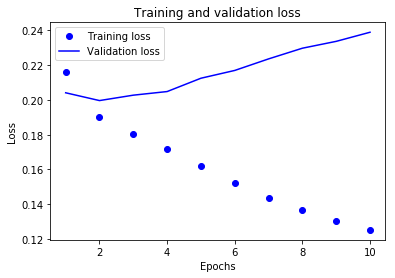

In [22]:
import matplotlib.pyplot as plt

def plt_loss():
    try:
        acc = history.history['acc']
        val_acc = history.history['val_acc']
    except KeyError:
        acc = history.history['binary_accuracy']
        val_acc = history.history['val_binary_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # "bo" is for "blue dot"
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plt_loss()
plt.show()

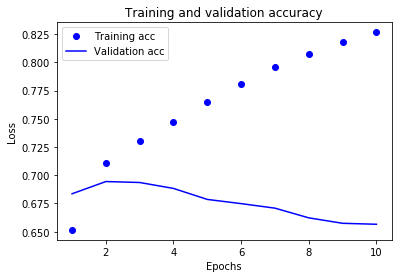

In [23]:
plt.clf()   # clear figure

def plt_acc():
    try:
        acc = history.history['acc']
        val_acc = history.history['val_acc']
    except KeyError:
        acc = history.history['binary_accuracy']
        val_acc = history.history['val_binary_accuracy']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plt_acc()
plt.show()

L'algorithme overfit largement. On peut arrêter l'entraînement après 4 étapes pour éviter cette dégénérescence.

In [26]:
model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))

model.add(Flatten())

model.add(Dense(16, activation='relu', input_shape=(10000,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
#              loss='mse',
              metrics=['acc'])

history = model.fit(x_train, y_train, epochs=4, batch_size=512, validation_split=0.2)

Train on 93638 samples, validate on 23410 samples
Epoch 1/4
93638/93638 [==============================] - 2s 17us/step - loss: 0.2325 - acc: 0.6124 - val_loss: 0.2114 - val_acc: 0.6707
Epoch 2/4
93638/93638 [==============================] - 1s 14us/step - loss: 0.1933 - acc: 0.7061 - val_loss: 0.1980 - val_acc: 0.6962
Epoch 3/4
93638/93638 [==============================] - 1s 12us/step - loss: 0.1759 - acc: 0.7414 - val_loss: 0.1980 - val_acc: 0.6960
Epoch 4/4
93638/93638 [==============================] - 1s 12us/step - loss: 0.1639 - acc: 0.7633 - val_loss: 0.2019 - val_acc: 0.6942


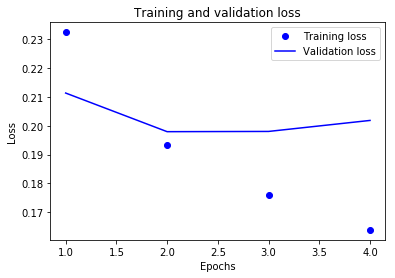

In [27]:
plt.clf()
plt_loss()
plt.show()

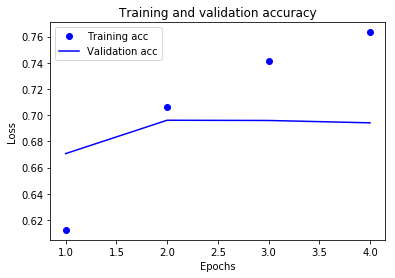

In [28]:
plt.clf()
plt_acc()
plt.show()

J'ai essayé la fonction de perse `mse` au lieu de `binary_crossentropy`, les résultats sont sensiblement identiques.
